# Frauddetection demo notebook
This notebook is a fork of the [frauddetection-notebook-template](https://gitlab.com/opendatahub/fraud-detection-tutorial/blob/master/jupyterhub/frauddetection-notebook-template.ipynb).
The data originates from [Kaggle/ULB](https://www.kaggle.com/mlg-ulb/creditcardfraud).

## The demo contains following steps:
- Start a spark session
- Load training data from Ceph/S3 into Spark
- Train and save a model
- Show accuracy and confusion matrix
- Upload the model to Ceph/S3 

## Start a spark session and load training data from S3 into Spark

In [1]:
import boto3
import pyspark
import time
import os
import socket
from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings('ignore')

print("Getting a spark session ...")
        

# Add the necessary Hadoop and AWS jars to access Ceph from Spark
os.environ['PYSPARK_SUBMIT_ARGS'] = '--conf spark.jars.ivy=/tmp/.ivy2 --packages com.amazonaws:aws-java-sdk:1.7.4,org.apache.hadoop:hadoop-aws:2.7.3 pyspark-shell'

spark = SparkSession.builder.master('local[2]').getOrCreate()
spark.sparkContext.setLogLevel("DEBUG")

print("Spark version:", spark.sparkContext.version)
print("Spark Session Success:", spark.range(5, numPartitions=5).rdd.map(lambda x: socket.gethostname()).distinct().collect())


Getting a spark session ...
Spark version: 2.2.1
Spark Session Success: ['jupyterhub-nb-kube-3aadmin']


## Set Ceph/S3 paramters and test connection

In [2]:
s3_region = '' # fill in for AWS, blank for Ceph

s3_endpoint_url= 'http://10.32.111.87:8000' # Change to your S3 URL
s3_access_key = os.environ['AWS_ACCESS_KEY_ID'] 
s3_secret_key = os.environ['AWS_SECRET_ACCESS_KEY']

s3_bucket = 'fraud-demo'
training_data_file = "creditcard-sample10k.csv"

s3 = boto3.client(service_name='s3',aws_access_key_id = s3_access_key,aws_secret_access_key = s3_secret_key, endpoint_url=s3_endpoint_url)


test_s3 = True
if test_s3:
   result = s3.list_objects(Bucket=s3_bucket)
   print("Objects in bucket:", s3_bucket)
   for item in result['Contents']:
     print(item['Key'])


Objects in bucket: fraud-demo
creditcard-sample10k.csv
creditcard.csv


## Load training data from S3 into Spark

In [3]:
print("Load training data from S3 into Spark ...")

hadoopConf=spark.sparkContext._jsc.hadoopConfiguration()
hadoopConf.set("fs.s3a.endpoint", s3_endpoint_url)
hadoopConf.set("fs.s3a.access.key", s3_access_key)
hadoopConf.set("fs.s3a.secret.key", s3_secret_key)
hadoopConf.set("fs.s3a.path.style.access", "true")
hadoopConf.set("fs.s3a.connection.ssl.enabled", "false") # false if not https


print("Spark reading transaction data ...")
df = spark.read.format("csv").option("header", "true").option("inferSchema", "True").option("mode", "DROPMALFORMED").load(f"s3a://{s3_bucket}/{training_data_file}")

print("Total number of credit card transaction rows: %d" % df.count())
### Check the total number of rows with fraud is detected
print("Total number of rows with fraud", df[(df['Class']==1)].count())

Load training data from S3 into Spark ...
Spark reading transaction data ...
Total number of credit card transaction rows: 10000
Total number of rows with fraud 38


# Train Sklearn Random Forest Model

## Split training and test set

In [25]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib


#Order the credit card transaction by transaction time
df.orderBy("Time")

#number of rows in the dataset
n_samples = df.count()
print("Toyal samples:", n_samples)

#Split into train and test
train_size = 0.75

train_limit = int(n_samples * train_size)
df_train = df.limit(train_limit)     
df_test = df.subtract(df_train) 


Toyal samples: 10000


In [5]:
print('Number of train transactions:', df_train.count())
print('Number of test  transactions:', df_test.count())
#Data Schema
print("Original Data Schema")
df_test.printSchema()

Number of train transactions: 7500
Number of test  transactions: 2500
Original Data Schema
root
 |-- _c0: integer (nullable = true)
 |-- Time: integer (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Define features and target variables for convenience.
drop_time_class = ['_c0', 'Time', 'Class']
drop_class=['Class']

#Create Train Datasets
features_train = df_train.drop(*drop_time_class)
target_train = df_train.select("Class")

#Create Test Datasets
features_test = df_test.drop(*drop_time_class)
target_test = df_test.select("Class")

#Create a RandomForest Classifier mode
model = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=10)

#Convert to pandas
features_test_pd = features_test.toPandas()
target_test_pd = target_test.toPandas()

features_train_pd = features_train.toPandas()
target_train_pd = target_train.toPandas()

model.fit(features_train_pd, target_train_pd.values.ravel())

pred_train = model.predict(features_train_pd)
pred_test = model.predict(features_test_pd)

pred_train_prob = model.predict_proba(features_train_pd)
pred_test_prob = model.predict_proba(features_test_pd)


score = accuracy_score(target_test_pd, model.predict(features_test_pd))
print("Model accuracy score: ",score)



Model accuracy score:  0.9992


In [20]:
joblib.dump(model, 'model.pkl') 

['model.pkl']

# Confusion Matrix

In [7]:
%%bash
pip3 install matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.


Confusion Matrix test set:
[[2487    0]
 [   0   13]]


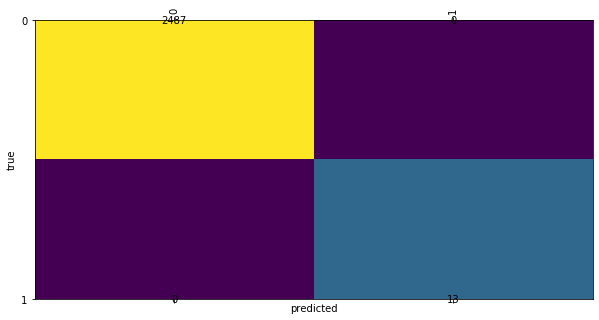

In [18]:
import matplotlib.pylab as plt
import matplotlib.colors
from sklearn.metrics import precision_recall_curve,\
                            average_precision_score,\
                            roc_auc_score, roc_curve,\
                            confusion_matrix, classification_report

def plot_confusion_matrix2(train_labels, train_pred):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot()

    labels = list(train_labels['Class'].value_counts().index)
 
    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    
    print(confusion)
    
    ax.matshow(np.log(confusion + 1.001))

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('predicted')    
    plt.ylabel('actual')
    
    return fig


#_=plot_confusion_matrix2(target_train_pd, model.predict(features_train_pd))


print("Confusion Matrix test set:")
_=plot_confusion_matrix2(target_test_pd, model.predict(features_test_pd))



# Upload Model to S3 Ceph

In [22]:
import boto3

key = "model-new.pkl"
s3.upload_file(Bucket=s3_bucket, Key=key, Filename="model.pkl")